In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from poliastro.bodies import Body
from poliastro.twobody import Orbit
from astropy.constants import Constant

import math
import time
import krpc
from functools import reduce
conn = krpc.connect(name='jupyter')
vessel = conn.space_center.active_vessel
krpc_bodies = conn.space_center.bodies

def _convert_body_krpc_to_poliastro(bodies, parent, krpc_body):
    name = krpc_body.name
    GM = Constant('GM_k{}'.format(name), 'Kerbal {} gravitational constant'.format(name),
                  krpc_body.gravitational_parameter, 'm3 / (s2)', 0,
                  'kRPC space_center.bodies["{}"].gravitational_parameter'.format(name), system='si')
    R = Constant('R_k{}'.format(name), 'Kerbal {} equatorial radius'.format(name),
                      krpc_body.equatorial_radius, 'm', 0,
                     'kRPC space_center.bodies["{}"].equatorial_radius'.format(name), system='si')
    body = Body(parent, GM, "", name, R)
    bodies[name] = body
    for satelite in krpc_body.satellites:
        _convert_body_krpc_to_poliastro(bodies, body, satelite)
    return

def convert_bodies_krpc_to_poliastro(bodies, krpc_bodies):
    krpc_Sun = krpc_bodies["Sun"]
    _convert_body_krpc_to_poliastro(bodies, None, krpc_Sun)
    return
    
bodies = {}
convert_bodies_krpc_to_poliastro(bodies, krpc_bodies)

In [37]:
reference_frame = krpc_bodies["Kerbin"].non_rotating_reference_frame

r_mun = krpc_bodies["Mun"].position(reference_frame) * u.m
v_mun = krpc_bodies["Mun"].velocity(reference_frame) * u.m / u.s

ss_mun = Orbit.from_vectors(bodies["Kerbin"], r_mun, v_mun)

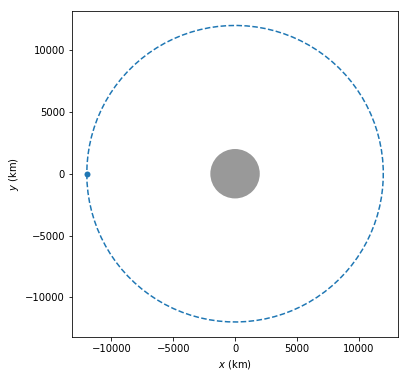

In [3]:
from poliastro.plotting import plot
plot(ss_mun)

In [38]:
r_i = vessel.position(reference_frame) * u.m
v_i = vessel.velocity(reference_frame) * u.m / u.s
ss_i = Orbit.from_vectors(bodies["Kerbin"], r_i, v_i)

In [39]:
from poliastro.maneuver import Maneuver
mun_apoapsis = krpc_bodies["Mun"].orbit.apoapsis
hoh = Maneuver.hohmann(ss_i, mun_apoapsis * u.m)
hoh.get_total_cost()

<Quantity 1.1866881061733316 km / s>

In [40]:
hoh.get_total_time()

<Quantity 26814.322956551547 s>

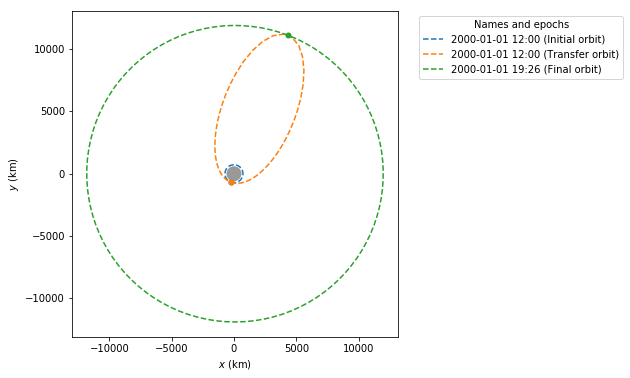

In [41]:
from poliastro.plotting import OrbitPlotter

op = OrbitPlotter()
ss_a, ss_f = ss_i.apply_maneuver(hoh, intermediate=True)
op.plot(ss_i, label="Initial orbit")
op.plot(ss_a, label="Transfer orbit")
op.plot(ss_f, label="Final orbit")

In [19]:
from poliastro.util import norm
delta_v = norm(tuple(val.decompose([u.m, u.s]) for val in hoh[0])[1])

In [24]:
delta_v.value

836.657547108947

In [51]:
def _hohmann_transfer_to_target(vessel, target, t: float):
    r_i = vessel.orbit.radius_at(t)
    v_i = vessel.orbit.orbital_speed_at(t)
    r_f = target.orbit.radius_at(t)
    k = vessel.orbit.body.gravitational_parameter
    R = r_f / r_i
    dv_a = ((math.sqrt(2 * R / (1 + R)) - 1) * v_i)
    dv_b = (1 - math.sqrt(2 / (1 + R))) / math.sqrt(R) * v_i
    t_trans = (math.pi * math.sqrt((r_i * (1 + R) / 2) ** 3 / k))
    
    pa = (target.orbit.true_anomaly_at_ut(t + t_trans) - (vessel.orbit.true_anomaly_at_ut(t) + math.pi) ) % (2 * math.pi) - math.pi
    
    return ((dv_a, dv_b), t_trans, pa)

In [53]:
ut = conn.space_center.ut
vessel = conn.space_center.active_vessel
target = conn.space_center.target_body
(dv_a, dv_b), trans_t, pa = _hohmann_transfer_to_target(vessel, target, ut)
vessel.control.add_node(ut, prograde=dv_a)
vessel.control.add_node(ut+trans_t, prograde=dv_b)
print(dv_a, dv_b, trans_t, pa)

827.2871009857298 359.995921651139 26814.911526007974 1.8066880819021085


In [56]:
list(range(1,30))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]